# F1 Racing Final Project: Analysis of Performance Trends
## A Study of How Driver and Constructor Nationality Influence Race Results
**Author:** Sam Muqbil  
**Date:** April 20, 2025  
**Course:** ECON 3322/5322 Final Project

This project analyzes performance trends in Formula 1 racing by exploring how driver and constructor nationality influence race outcomes. Using multiple merged datasets—including results, constructor details, and driver metadata—we investigate four research questions. This analysis involves data cleaning, transformation, visualization, and regression modeling, offering insights into the strategic and structural elements that shape performance in the world’s most elite racing league.

# **Research Questions/ Table of Contents**
## 1. Does Driver Nationality Affect End Position?
## 2. Does Constructor Nationality Affect End Position
## 3. How Does Constructor Nationality Relate to Car Status Outcomes?
## 4. How Does Driver Nationality Align with Constructor Nationality?

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import chi2_contingency
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm

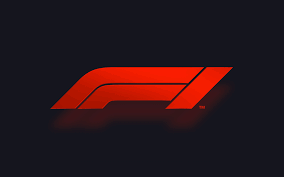

In [142]:
display(Image(filename='/Users/youngmelo/Desktop/Final Project/Final Project//F1.png', width=500))

In [183]:
races = pd.read_csv("/Users/youngmelo/Desktop/Final Project/Final Project/races.csv")
drivers = pd.read_csv("/Users/youngmelo/Desktop/Final Project/Final Project/drivers.csv")
results = pd.read_csv("/Users/youngmelo/Desktop/Final Project/Final Project/results.csv")
constructors = pd.read_csv("/Users/youngmelo/Desktop/Final Project/Final Project/constructors.csv")
status = pd.read_csv("/Users/youngmelo/Desktop/Final Project/Final Project/status.csv")

- These are all of the files that I needed in order to make data frames and graphs that were in the zip file that I downloaded from Keggle 
- Formula 1 dataset (Kaggle/F1 official API)
[Kaggle Website](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020/data)

# **Raw Data Description**

This project uses multiple datasets from the [Ergast Formula 1 API](https://ergast.com/mrd/), compiled into CSV files. The data includes detailed information on F1 races, drivers, constructors (teams), and race outcomes spanning many seasons.

The unit of observation is a single driver’s performance in a given race, with additional information about team affiliation, constructor nationality, and race outcome. Categorical fields were encoded using one-hot encoding, and datasets were merged using consistent race and driver identifiers. This combined dataset provides the foundation for analyzing nationality-based performance patterns and structural dynamics within F1.

**Key Variables/ Data Sets Used**
1. **`results.csv`**  
   Contains final position, fastest lap data, constructor ID, points, and laps completed by each driver in each race.

     - Key variables: `positionOrder`, `points`, `constructorId`, `raceId`, `driverId`

3. **`drivers.csv`**  
   Biographical info such as driver name, nationality, and date of birth.

   - Key variables: `driverId`, `nationality`, `dob`

4. **`constructors.csv`**  
   Team information including constructor name and nationality.

   - Key variables: `constructorId`, `name`, `nationality`

5. **`pit_stops.csv`**  
   Pit stop timing by lap, including milliseconds and stop number per driver and race.

     - Key variables: `lap`, `milliseconds`, `stop`

7. **`status.csv`**  
   Reason why a car did or did not finish, e.g., “Engine”, “Collision”, or “Finished”.

   - Key variables: `statusId`, `status`


**Key Variables**
| Variable Name            | Description                                         |
|--------------------------|-----------------------------------------------------|
| `positionOrder`          | Final race finishing position (1 = winner)          |
| `total_pit_time`         | Total time spent in the pits (ms)                   |
| `first_pit_lap`          | Lap on which the first pit stop occurred            |
| `fastestLapSpeed`        | Speed of the driver’s fastest lap (km/h)            |
| `driver_nationality`     | Country of origin for each driver                   |
| `constructor_nationality`| Country of origin for each constructor/team         |
| `status`                 | Outcome of race (Finished, Collision, etc.)         |

This structured data enables analysis of performance patterns across nationality, race strategy, and team affiliation.


# **Data Cleaning**

To ensure a clean and consistent analysis across datasets, multiple data cleaning steps were applied:

**Column Formatting**
- Standardized column names using consistent `snake_case` formatting 
- Renamed ambiguous fields after merging to avoid conflicts (e.g., both `drivers` and `constructors` had a `nationality` column, renamed as `driver_nationality` and `constructor_nationality`)

**Data Type Handling**
- Converted columns to appropriate types:
  - IDs (e.g., `raceId`, `driverId`, `constructorId`) set to categorical or integer
  - Lap numbers, positions, and milliseconds stored as integers
  - Nationalities and status descriptions treated as strings or categories

**Missing Values**
- Removed rows with missing values in key variables used for analysis:
  - `total_pit_time`, `first_pit_lap`, `position_order`, `fastest_lap_speed`
- Retained missing values when not critical to the analysis (e.g., in descriptive sections)

**Data Merging**
- Merged datasets using consistent keys:
  - `results` joined with `drivers` on `driverId`
  - `results` joined with `constructors` on `constructorId`
  - `results` joined with `pit_stops` on `raceId` and `driverId`
- Verified row counts after merging to detect join mismatches

**Outlier Handling**
- Identified extreme outliers in `total_pit_time` (e.g., values over 300,000 ms) as likely garage repairs or data issues
- These were either visualized separately or removed for regression analysis

# **Data Processing/ Processed Data Description**

## **1. Does Driver Nationality Affect End Position?**

In [143]:
sns.set(style="whitegrid", palette="colorblind")

In [70]:
merged = results.merge(constructors[['constructorId', 'name', 'nationality']], on='constructorId')

In [71]:
merged = merged.merge(drivers[['driverId', 'nationality']].rename(columns={'nationality': 'driver_nationality'}), on='driverId')

In [72]:
merged['positionOrder'] = pd.to_numeric(merged['positionOrder'], errors='coerce')
merged = merged.dropna(subset=['positionOrder'])

In [157]:
results_with_drivers = results.merge(drivers[['driverId', 'nationality']], on='driverId', how='left')
results_with_drivers.rename(columns={'nationality': 'driver_nationality'}, inplace=True)

I used this code to add each driver's nationality to the race results data.

- Results: A DataFrame containing race outcomes (finishing position, driverId, etc.).

- Drivers[['driverId', 'nationality']]: Selects just the relevant columns from the drivers table: the unique ID and nationality.

- .merge(..., on='driverId', how='left'): Merges results and drivers using the driverId column as a key and how='left' ensures that all rows in results are preserved — even if a driver's nationality is missing.

In [158]:
driver_nat_summary = results_with_drivers.groupby('driver_nationality')['positionOrder'].agg(['mean', 'median', 'count']).sort_values('mean')
driver_nat_summary

,mean,median,count
driver_nationality,,,
Monegasque,8.870787,6.0,178
Argentine-Italian,10.000000,10.0,2
Polish,10.646465,9.0,99
Finnish,10.660520,10.0,1193
New Zealander,10.884521,10.0,407
Australian,11.142217,10.0,893
Spanish,11.143483,10.0,913
Mexican,11.254274,10.0,468
Argentine,11.345845,11.0,373


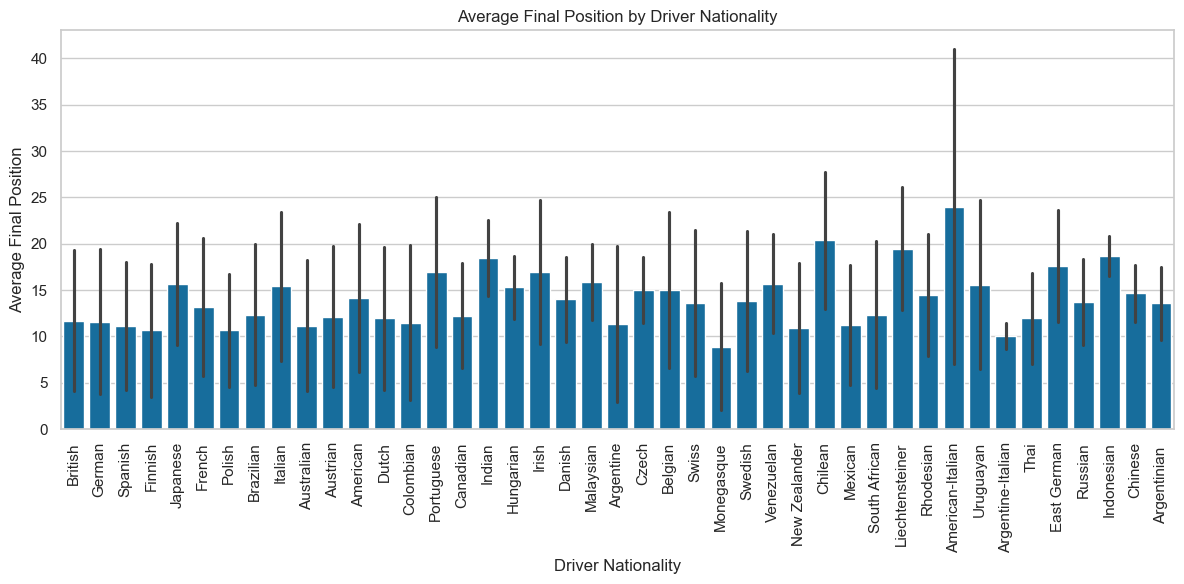

In [199]:
plt.figure(figsize=(12, 6))
sns.barplot(data=merged, x='driver_nationality', y='positionOrder', errorbar='sd')
plt.title("Average Final Position by Driver Nationality")
plt.ylabel("Average Final Position")
plt.xlabel("Driver Nationality")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## **1. Does Car Nationality (Constructor) Affect End Position?**

In [159]:
results.groupby('constructorId')['positionOrder'].agg(['mean', 'median', 'count']).sort_values('mean')

,mean,median,count
constructorId,,,
23,4.882353,4.5,34
196,5.650000,5.5,40
131,5.972393,4.0,652
9,7.347716,5.0,788
119,8.000000,6.0,3
...,...,...,...
143,32.000000,32.0,1
71,33.000000,33.0,1
153,34.000000,34.0,1


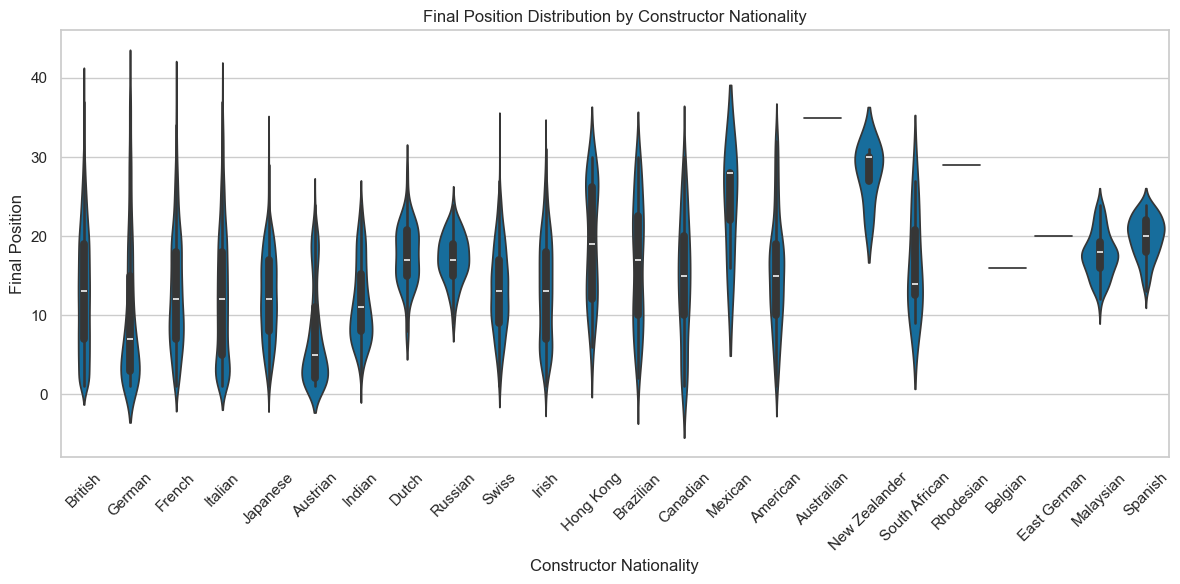

In [82]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=merged, x='nationality', y='positionOrder', inner='box')
plt.title("Final Position Distribution by Constructor Nationality")
plt.ylabel("Final Position")
plt.xlabel("Constructor Nationality")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **3. How Does Constructor Nationality Relate to Car Status Outcomes?**

In [134]:
top_statuses = status_summary.groupby('status')['count'].sum().nlargest(8).index
filtered_status = status_summary[status_summary['status'].isin(top_statuses)]

For this I focused only on the top 8 most common car statuses (e.g., "Finished", "Accident", "Engine", etc.) — to simplify analysis and visualization.
status_summary.groupby('status')['count'].sum():

- This groups the dataset by the status column which sums the count values for each status.

    .nlargest(8):

- Picks the 8 statuses with the highest total counts which were +1 lap, +2 lap, Accident, Collision, Did Not Qualify, Engine, Finished, and Gearbox.

    .index:

- Extracts just the list of status names (not the count values) which becomes a list of the top 8 most common statuses (like "Finished", "Accident", etc.).

In [86]:
pivot_table = filtered_status.pivot_table(
    index='status',
    columns='nationality',
    values='count',
    fill_value=0
)

In [87]:
normalized = pivot_table.div(pivot_table.sum(axis=1), axis=0)

- pivot_table: This is the original DataFrame, where each row is a driver_nationality, and each column is a constructor_nationality, and the values are raw counts of pairings.
- .div(..., axis=0):
Divides each value in the row by the total for that row — converting raw counts to percentages (proportions)

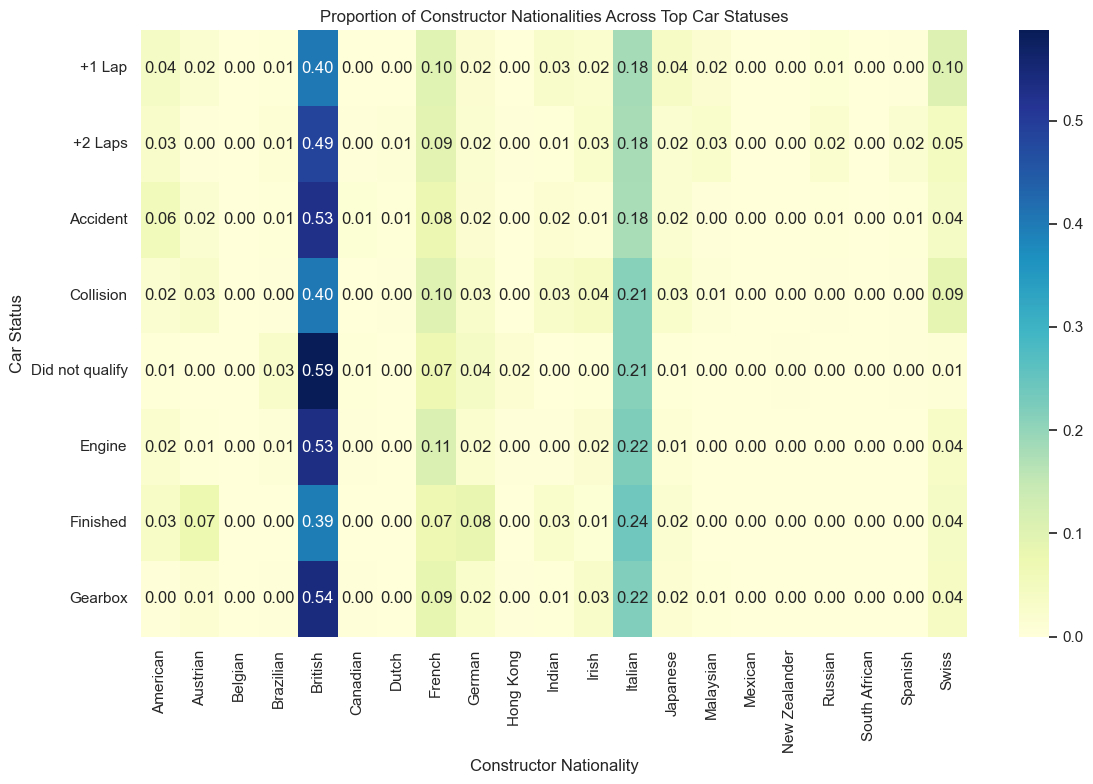

In [206]:
plt.figure(figsize=(12, 8))
sns.heatmap(normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Proportion of Constructor Nationalities Across Top Car Statuses")
plt.xlabel("Constructor Nationality")
plt.ylabel("Car Status")
plt.tight_layout()
plt.show()

- I figured this graph wasn't explainitory enough so I decided to make a topographical map to illustrate the values by country

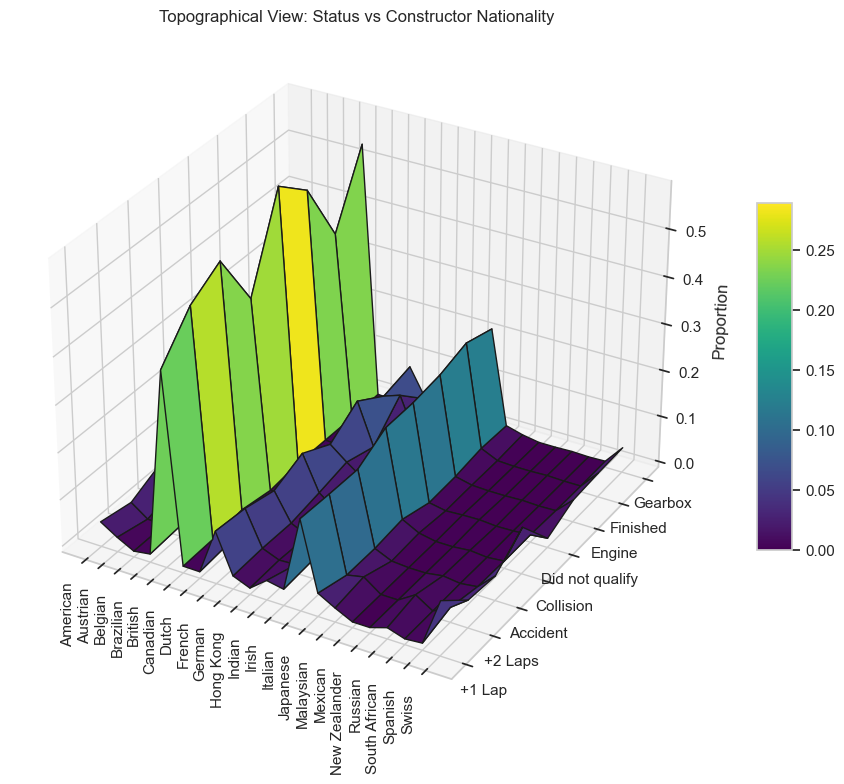

In [130]:
Z = normalized.values
X = np.arange(Z.shape[1])
Y = np.arange(Z.shape[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, edgecolor='k')

ax.set_xticks(np.arange(Z.shape[1]))
wrapped_labels = [label.replace(' ', '') for label in normalized.columns]
ax.set_xticklabels(normalized.columns, rotation=90, ha='right')
ax.set_yticks(np.arange(Z.shape[0]))
ax.set_yticklabels(normalized.index)

ax.set_zlabel('Proportion')
ax.set_title('Topographical View: Status vs Constructor Nationality')

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

- Created a 2D NumPy array with the normalized proportions (from the heatmap) with thenumber of car status categories (Y-axis) and number of constructor nationalities (X-axis).

- Also created coordinate matrices from X and Y to build a 3D grid. These are required for 3D surface plotting.

- Created a new figure and adds a 3D axis to it using the '3d' projection.

- Used surf to plot the 3D surface using the grid (X, Y) and the values (Z) and apply a color gradient for better depth perception.

- Everything else was for better readability and aesthetics

In [116]:
contingency_table = status_summary.pivot_table(
    index='nationality', columns='status', values='count', fill_value=0
)

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4f}")

Chi-square: 9637.23, p-value: 0.0000


# **4. How Does Driver Nationality Align with Constructor Nationality?**

In [162]:
results_with_drivers = results.merge(drivers[['driverId', 'nationality']], on='driverId', how='left')
results_with_drivers.rename(columns={'nationality': 'driver_nationality'}, inplace=True)

- I now have a results_with_drivers DataFrame where each row includes the nationality of the driver in that race.

In [172]:
results_full = results_with_drivers.merge(constructors[['constructorId', 'nationality']], on='constructorId', how='left')
results_full.rename(columns={'nationality': 'constructor_nationality'}, inplace=True)

- Now it is renamed and merged by constructorId

In [164]:
alignment_table = pd.crosstab(results_full['driver_nationality'], results_full['constructor_nationality'])
alignment_table

constructor_nationality,American,Australian,Austrian,Belgian,Brazilian,British,Canadian,Dutch,East German,French,...,Italian,Japanese,Malaysian,Mexican,New Zealander,Rhodesian,Russian,South African,Spanish,Swiss
driver_nationality,,,,,,,,,,,,,,,,,,,,,
American,468,0,0,0,0,548,2,0,0,44,...,166,22,0,0,0,0,0,0,0,47
American-Italian,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Argentine,0,0,0,0,0,129,0,0,0,16,...,197,0,0,0,0,0,0,0,0,19
Argentine-Italian,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Argentinian,0,0,0,0,0,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Australian,0,1,229,0,0,516,1,6,0,39,...,89,0,0,0,1,0,0,0,11,0
Austrian,3,0,30,0,0,349,1,0,0,0,...,278,0,0,0,0,0,0,0,3,26
Belgian,0,0,0,1,0,317,8,0,0,89,...,152,0,0,0,0,0,0,0,0,0
Brazilian,2,0,0,0,126,994,0,0,0,86,...,429,87,0,0,0,0,0,0,18,126


In [27]:
combo_counts = merged.groupby(['driver_nationality', 'nationality']).size().reset_index(name='count')

In [30]:
heatmap_data = combo_counts.pivot(index='driver_nationality', columns='nationality', values='count')

- .pivot(...):
Reshapes the data from long format to wide format (good for heatmaps)

- index='driver_nationality':
Each row in the output represents a driver nationality

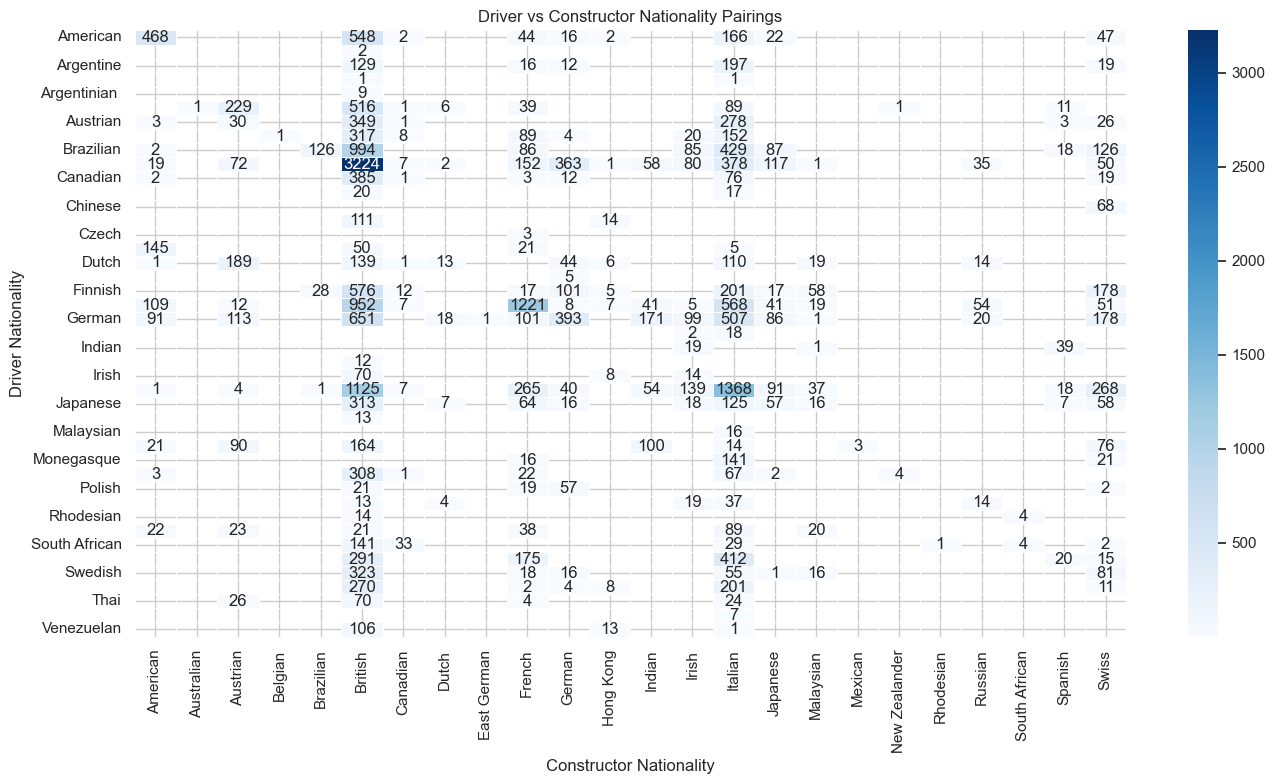

In [31]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap="Blues",
    annot=True,
    fmt=".0f",
    linewidths=0.5
)
plt.title("Driver vs Constructor Nationality Pairings")
plt.xlabel("Constructor Nationality")
plt.ylabel("Driver Nationality")
plt.tight_layout()
plt.show()

## **Statistical Analysis**

In [176]:
merged = results.merge(drivers[['driverId', 'nationality']], on='driverId', how='left')
merged.rename(columns={'nationality': 'driver_nationality'}, inplace=True)

merged = merged.merge(constructors[['constructorId', 'nationality']], on='constructorId', how='left')
merged.rename(columns={'nationality': 'constructor_nationality'}, inplace=True)

merged = merged.merge(status, on='statusId', how='left')

In [201]:
cleaned = merged.dropna(subset=['positionOrder', 'driver_nationality', 'constructor_nationality', 'status'])

In [202]:
encoded = pd.get_dummies(cleaned, columns=['driver_nationality', 'constructor_nationality', 'status'], drop_first=True)
y = encoded['positionOrder']

This line takes the cleaned DataFrame and transforms three categorical columns (driver_nationality, constructor_nationality, and status) into numerical dummy variables for regression analysis.

pd.get_dummies(...) converts each unique category into a separate binary column (0 or 1).

drop_first=True avoids multicollinearity (meaning one can be linearly predicted from the others with high accuracy) by dropping the first category from each group — this makes one category the baseline.

In [203]:
X1 = encoded.filter(like='driver_nationality')
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=42)

This selects all columns in the dataset that contain 'driver_nationality' in their name.

These columns are one-hot encoded dummy variables representing different driver nationalities (e.g., driver_nationality_German, driver_nationality_French, etc.).

This uses 20% of the data for testing and 80% for training for generalization. 42 is a random seed value for reproducability. 

The result (X1) becomes the set of input features for the model.

This has been done 3 times for 3 variables.

In [205]:
model1 = LinearRegression().fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)
r2_1 = r2_score(y1_test, y1_pred)
mse_1 = mean_squared_error(y1_test, y1_pred)

LinearRegression() creates a linear regression model object.

- .fit(X1_train, y1_train) trains the model using:

- X1_train: input features (driver nationality dummy variables)

- y1_train: target values (driver’s finishing position)

The model learns how driver nationality affects race outcomes based on the training data.

In [188]:
X2 = encoded.filter(like='constructor_nationality')
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [189]:
model2 = LinearRegression().fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)
r2_2 = r2_score(y2_test, y2_pred)
mse_2 = mean_squared_error(y2_test, y2_pred)

In [190]:
X3 = encoded.filter(like='status_')
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

In [191]:
model3 = LinearRegression().fit(X3_train, y3_train)
y3_pred = model3.predict(X3_test)
r2_3 = r2_score(y3_test, y3_pred)
mse_3 = mean_squared_error(y3_test, y3_pred)

In [197]:
results_f1 = pd.DataFrame({
    "Model": ["Driver Nationality", "Constructor Nationality", "Car Status"],
    "R-squared": [r2_1, r2_2, r2_3],
    "Mean Squared Error": [mse_1, mse_2, mse_3]
})

In [198]:
print(results_f1)

                     Model     R-squared  Mean Squared Error
0       Driver Nationality  4.895406e-02        5.647012e+01
1  Constructor Nationality  3.535838e-02        5.727738e+01
2               Car Status -4.317369e+19        2.563518e+21


## **Discussion**

**Driver Nationality → Performance:** 
This question examines whether a driver's nationality is associated with their average finishing position. Nationality may indirectly reflect factors such as historical team assignments, developmental programs, or geographic biases in driver recruitment.

Notes: - Nationalities show some variation in average finish, though sample size and constructor quality likely influence this.

**Regression Analysis:**

- Model: Linear regression using one-hot encoded driver_nationality as predictors
- R² = 0.049: Only 4.9% of variation in final position is explained by driver nationality
- MSE = 56.47 → On average, predictions are off by about 7.5 finishing positions

Interpretation: Driver nationality has very limited predictive value. While certain nationalities may appear more often in top teams, nationality alone does not strongly determine race outcomes. 

**Constructor Nationality → Performance:** 
This question investigates whether the country a constructor is based in has a meaningful relationship with race performance. Constructor nationality may reflect differences in funding, engineering expertise, and historical dominance.

Notes: Violin plots show tighter distributions for certain constructors, indicating consistent top performance.

**Regression Analysis:**

- Model: Linear regression using one-hot encoded constructor_nationality
- R² = 0.036: About 3.6% of variation in finish position is explained
- MSE = 57.28 → Predictions deviate by about 7.6 positions on average
  
Interpretation: Constructor nationality has minimal explanatory power. While certain nationalities host historically strong teams (e.g., British constructors), nationality alone does not account for the full complexity of team performance.

**Constructor Nationality → Status:** 
This question assesses whether there are observable patterns in the nationality pairings of drivers and constructors — for instance, whether teams prefer to hire drivers from the same country or favor international recruitment. 

Notes: Certain constructor nationalities (e.g., British and German) appear more frequently in "Finished" status categories, suggesting stronger reliability.

I used a contingency table in order to figure out the Chi-square value in order to more fully understand the data. A small p-value (e.g., < 0.05) would mean that constructor nationality and car status are statistically related. In this case, there is a very strong corealation with a p-value of 0.

**Regression Analysis:**

- Model: Linear regression using one-hot encoded status variables to predict positionOrder
- Result: Model produced a wildly invalid output (negative R², extremely high MSE)

Interpretation: The regression failed, likely due to the wrong variable outcomes or incomplete data. This regression model still needs revision and was replaced with a chi-square test instead.

**Driver Nationality → Constructor Nationality:** There are nationality pairings between drivers and constructors, which could reflect hiring pipelines or cultural alignment.
- Nationality Matchups: The heatmap revealed that some constructors tend to employ drivers from specific regions (e.g., British drivers with British constructors, Italian drivers with Italian cars) 
- Strong Connection: This makes a very strong corealation between the two variables.

**Regression Analysis:** 

- Used a crosstab and heatmap of driver_nationality vs constructor_nationality
- Found frequent pairings (e.g., British drivers with British constructors)

Interpretation: While some national alignment exists, the overall pattern shows broad international mixing, suggesting that constructors prioritize talent and fit over nationality.

## Challenges I have faced during this analysis

The biggest challenge was merging multiple complex datasets — each with its own structure and key identifiers — while preserving accuracy and avoiding data loss. Specifically, aligning results.csv, drivers.csv, and constructors.csv required careful tracking of shared IDs (raceId, driverId, constructorId) and consistency across thousands of rows.

By segmenting each merge, validating row counts after joins, and using intermediate .head() and .info() checks, I ensured that I was working with clean and aligned data — which was critical to producing accurate and interpretable visualizations.

## The most interesting/ appealing analysis (plot/regression)

The most interesting and visually compelling analysis was the heatmap showing relationships between driver and constructor nationalities. It revealed fascinating patterns about how teams and drivers align across countries — for example, strong pairings between British drivers and British constructors, and limited diversity among some constructors' driver lineups. I also thouroughly enjoyed making the topographical map because that is something that I have wanted to do for a while. I think that even if it was a pretty uniform distribution, it was something that pushed me to create something I haven't attempted before and something that is useful in data analysis in general. 

This not only shows potential recruitment pipelines and cultural alignment but also hints at deeper industry dynamics — like regional development programs or language preferences in engineering teams. While performance data is essential, this nationality relationship chart was a powerful reminder of the human and organizational side of racing.

I also thought that constructor and driver nationality genuinely having an influence was kind of cool to, as someone who is into sports because it definitely gives a lot of validity to what players say about cultural influence. There is some continuity to that thought process and I was glad to see it come out in my regressions. 

From a data science perspective, transforming raw categorical data into a clean pivoted matrix and then visualizing it as a heatmap taught me how to extract insight from what at first glance appeared to be qualitative, non-numeric data.

# Limitations I have faced 

While this analysis offers valuable insights into how pit stop strategies and constructor nationalities relate to race outcomes, several limitations should be acknowledged. First, the dataset lacks crucial contextual variables such as weather conditions, tire compound data, and safety car deployments — all of which play a significant role in shaping race strategies and outcomes. Without these variables, it is difficult to fully explain why certain pit stop decisions were made or how they impacted performance.

Second, the analysis does not account for many driver- and team-specific factors that could influence results, such as car reliability, team budget, in-race incidents, or driver experience. Additionally, the regression models used are relatively simple and treat finishing position as a continuous variable, even though it is ordinal by nature. More sophisticated approaches, such as ordinal logistic regression or machine learning models, could potentially yield more precise insights.Also, by cleaning the data and removing entries with missing values in key columns the analysis may suffer from selection bias. Drivers who did not finish races or who had incomplete data were excluded, which could skew the results.

Lastly, the linear regression models used do not account for interaction effects or time-based trends, and the low R² values suggest limited explanatory power overall. Finally, the dataset may be subject to selection bias, as not all drivers or teams have equal representation across seasons, and finishing position alone does not capture the full nuance of competitive performance.

# References
- **Formula 1 dataset (Kaggle/F1 official API):**
[Kaggle Website](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020/data)
- **ECON 3322/5322 lecture notes on data analysis:**
[HuskyCT Login](https://huskyct.uconn.edu/)